In [1]:
import whisper
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from jiwer import wer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:

model = whisper.load_model("base") 


d:\Anaconda\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [3]:

def load_audio(audio_file):
    waveform, sample_rate = torchaudio.load(audio_file)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
    return waveform,sample_rate



In [4]:
import os
os.environ["PATH"] += os.pathsep + r"C:\ffmpeg\bin"  


In [5]:
def transcribe_audio(audio_file):
    waveform ,sr= load_audio(audio_file)
    temp_audio_path = "temp.wav"
    torchaudio.save(temp_audio_path, waveform, 16000)
    result = model.transcribe(temp_audio_path)
    return result['text']

audio_file = "timit/data/TRAIN/DR1/FCJF0/SA1.WAV"

predicted_text = transcribe_audio(audio_file)
print("Predicted Text:", predicted_text)

ground_truth_text = "She had your dark suit in greasy wash water all year"


d:\Anaconda\Lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Predicted Text:  She had a dark suit in greasy washwater all year.


In [6]:
print("Audio file path:", audio_file)


Audio file path: timit/data/TRAIN/DR1/FCJF0/SA1.WAV


In [7]:

error_rate = wer(ground_truth_text.lower(), predicted_text.lower())
print(f"Word Error Rate (WER): {error_rate:.2f}")

from jiwer import mer, wil

match_error_rate = mer(ground_truth_text.lower(), predicted_text.lower())
wil_rate = wil(ground_truth_text.lower(), predicted_text.lower())

print(f"Match Error Rate (MER): {match_error_rate:.2f}")
print(f"Word Information Lost (WIL): {wil_rate:.2f}")


Word Error Rate (WER): 0.36
Match Error Rate (MER): 0.36
Word Information Lost (WIL): 0.55


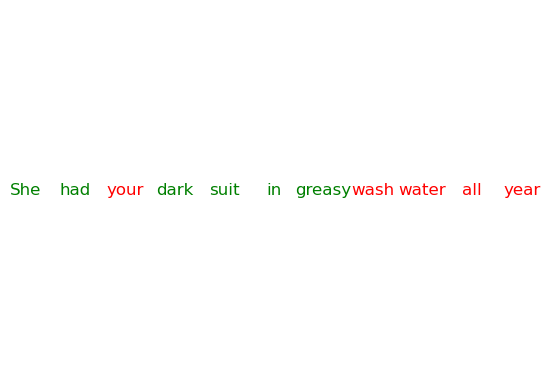

In [8]:
def visualize_pronunciation(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    
    fig, ax = plt.subplots()
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(idx * 0.1, 0.5, word, color=color, fontsize=12, ha='center')
    ax.axis('off')
    plt.show()

visualize_pronunciation(ground_truth_text, predicted_text)

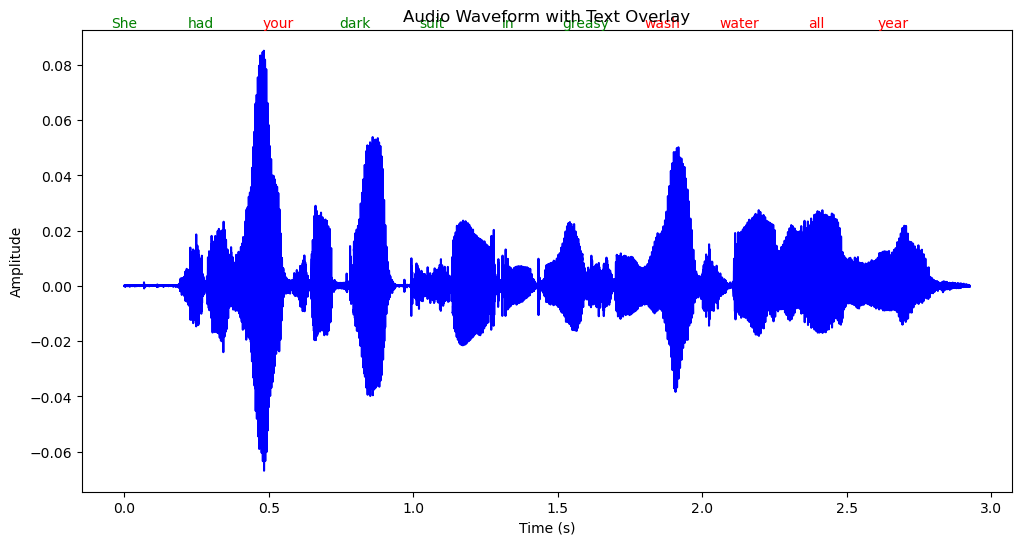

In [9]:
def visualize_audio_with_text_overlay(audio_file, ground_truth, predicted_text):
    waveform, sample_rate = load_audio(audio_file)
    ground_truth_words = ground_truth.split()
    predicted_words = predicted_text.split()

    total_time = waveform.size(1) / sample_rate
    word_times = np.linspace(0, total_time, len(ground_truth_words) + 1)

    fig, ax = plt.subplots(figsize=(12, 6))
    time_values = np.linspace(0, total_time, waveform.size(1))
    ax.plot(time_values, waveform[0].numpy(), color="blue")  

    max_amplitude = waveform[0].abs().max().item()

    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(word_times[idx], max_amplitude * 1.1, word, color=color, fontsize=10, ha='center')

    # Labels and title
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title("Audio Waveform with Text Overlay")
    plt.show()

visualize_audio_with_text_overlay(audio_file, ground_truth_text, predicted_text)


In [10]:

def evaluate_performance(ground_truth, predicted_text):
    ground_truth_words = ground_truth.split()
    predicted_words = predicted_text.split()

    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(ground_truth_words, predicted_words)]

    accuracy = accuracy_score([1]*len(labels), labels)
    precision = precision_score([1]*len(labels), labels)
    recall = recall_score([1]*len(labels), labels)
    f1 = f1_score([1]*len(labels), labels)

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = evaluate_performance(ground_truth_text, predicted_text)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.60
Precision: 1.00
Recall: 0.60
F1 Score: 0.75


C:\Users\51man\AppData\Local\Temp\ipykernel_20932\2587123866.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")


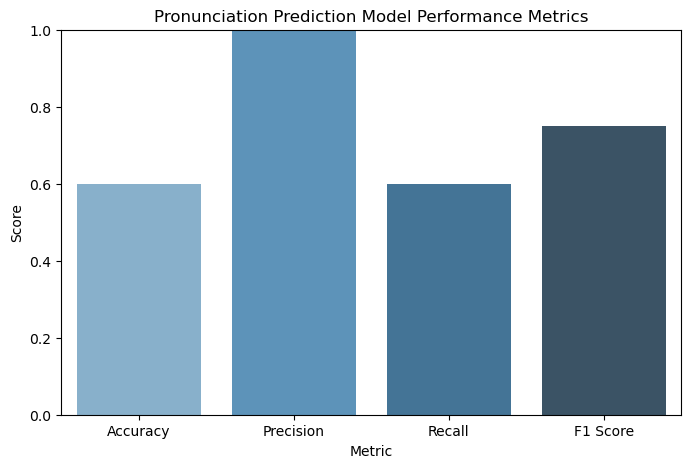

In [11]:

def plot_performance_metrics(accuracy, precision, recall, f1):
    metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
    plt.ylim(0, 1)
    plt.title("Pronunciation Prediction Model Performance Metrics")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_labels(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(ground_truth_words, predicted_words)]
    return labels

labels = get_labels(ground_truth_text, predicted_text)

accuracy = accuracy_score([1]*len(labels), labels)
precision = precision_score([1]*len(labels), labels)
recall = recall_score([1]*len(labels), labels)
f1 = f1_score([1]*len(labels), labels)

plot_performance_metrics(accuracy, precision, recall, f1)
